https://arxiv.org/abs/2205.10535

This study uses the gradient boosting version
implemented by Malohlava and Candel (2019) which is based on Hastie et al. (2017).
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html

# **Imports**

In [19]:
!pip install lime shap

In [20]:
!pip install h2o

In [21]:
import gdown  # to download data from google drive
import gzip   # to decompress downloaded data
import shutil

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [24]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator

In [25]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, precision_score, recall_score, f1_score, confusion_matrix

In [26]:
from sklearn.inspection import PartialDependenceDisplay

In [27]:
import lime
import lime.lime_tabular
import shap

#**Load and Split dataset**

In [28]:
def download_data(folder_id):
    url = f"https://drive.google.com/drive/folders/{folder_id}"
    # gdown URL formate
    gdown.download_folder(url=url, output="./downloaded_folder", quiet=False, use_cookies=False)

In [29]:
def decompress_gz(file_path, output_file_name):
    with gzip.open(file_path, 'rb') as f_in:
        with open(output_file_name, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [30]:
#if __name__ == '__main__':
    # downloading raw dataset
    #download_data("14ZG8utOf0Ry76w_T9rqrk5kdhhPIK84P")
    #decompress_gz('/content/downloaded_folder/accepted_2007_to_2018Q4.csv.gz', "accepted.csv")

In [31]:
data = pd.read_csv("/content/df_cleaned.csv", low_memory=False)
data.head()

,last_pymnt_d,total_rec_prncp,last_pymnt_amnt,out_prncp,total_rec_late_fee,last_fico_range_high,installment,loan_amnt,total_rec_int,out_prncp_inv,...,funded_amnt_inv,recoveries,debt_settlement_flag,hardship_flag,mo_sin_old_rev_tl_op,revol_util,dti,all_util,annual_inc,loan_status
0,17,-0.332581,-0.372797,0.420080,-0.261895,0.281611,-0.473027,-0.461473,0.413942,0.420298,...,-0.461004,-0.445598,0,0,-0.307356,0.608376,0.558953,0.915820,-1.203816,0.0
1,31,-0.840560,-0.473603,-0.629220,-0.261895,1.244049,-1.608631,-1.601510,-1.081823,-0.629167,...,-1.601271,-0.445598,0,0,-0.187187,-1.880835,-1.233491,-0.049124,0.274631,1.0
2,27,-0.250720,-0.222228,2.263937,-0.261895,0.883135,1.252073,1.058575,-0.380182,2.264445,...,1.059353,-0.445598,0,0,-0.980297,0.431193,-0.223328,0.379740,2.227297,1.0
3,39,-0.458023,0.161605,-0.629220,-0.261895,0.161306,-1.364264,-1.373503,-0.909433,-0.629167,...,-1.373218,-0.445598,0,0,-1.472987,0.314511,-0.337836,0.433348,-1.231711,1.0
4,5,-0.415519,0.220569,-0.629220,-0.261895,0.221459,-1.317547,-1.348168,-0.834440,-0.629167,...,-1.347878,-0.445598,0,0,0.738107,1.273894,0.117928,1.559116,-0.841178,1.0


In [32]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **GBM**

## **Model Arch**

In [34]:
h2o.init()

def GBM_model(X_train, y_train, X_test, y_test):
    """
    Train a Gradient Boosting Machine (GBM) model with specified hyperparameters and evaluate on test data.

    Parameters:
    X_train (DataFrame): Training features
    y_train (Series): Training labels
    X_test (DataFrame): Test features
    y_test (Series): Test labels

    Returns:
    H2OGradientBoostingEstimator: Trained GBM model
    """
    # Convert data to H2O frames
    train_h2o = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
    test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

    # Get column names
    feature_names = list(X_train.columns)
    target_name = y_train.name

    # Convert target to categorical for classification
    train_h2o[target_name] = train_h2o[target_name].asfactor()
    test_h2o[target_name] = test_h2o[target_name].asfactor()

    model = H2OGradientBoostingEstimator(
        ntrees=10,
        max_depth=15,
        min_rows=10,
        learn_rate=0.01,
        seed=42
    )

    model.train(x=feature_names, y=target_name, training_frame=train_h2o, validation_frame=test_h2o)

    return model

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8b4ud6nh
  JVM stdout: /tmp/tmp8b4ud6nh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8b4ud6nh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_nirzo3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [35]:
model = GBM_model(X_train, y_train, X_test, y_test)
predictions = model.predict(h2o.H2OFrame(X_test))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


## **Model Evaluation**

In [36]:
test_h2o = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

target_name = y_test.name
test_h2o[target_name] = test_h2o[target_name].asfactor()

perf = model.model_performance(test_data=test_h2o)

print("Model Evaluation on Test Set:")
print(f"AUC: {perf.auc():.4f}")
print(f"Accuracy: {perf.accuracy()[0][1]:.4f}")
print("Confusion Matrix:")
print(perf.confusion_matrix())

print(f"F1 Score: {perf.F1()[0][1]:.4f}")
print(f"Precision: {perf.precision()[0][1]:.4f}")
print(f"Recall: {perf.recall()[0][1]:.4f}")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Model Evaluation on Test Set:
AUC: 0.9965
Accuracy: 0.9835
Confusion Matrix:
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5030690662579386
       0     1     Error    Rate
-----  ----  ----  -------  --------------
0      4276  115   0.0262   (115.0/4391.0)
1      36    4703  0.0076   (36.0/4739.0)
Total  4312  4818  0.0165   (151.0/9130.0)
F1 Score: 0.9842
Precision: 1.0000
Recall: 1.0000


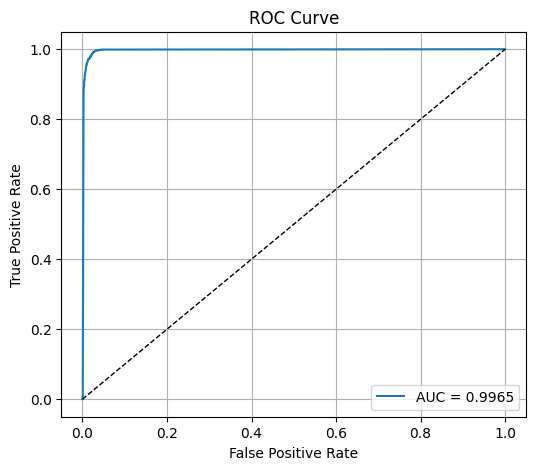

In [37]:
roc_table = perf.roc()

fpr, tpr = roc_table

roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})

fpr = roc_df['fpr']
tpr = roc_df['tpr']
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {perf.auc():.4f}")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

visualizing the trade-off between true positives (correctly identified positive cases) and false positives (incorrectly identified positive cases).

## **Model Explainability**

### **Feature Importance**

                 Feature    Importance
0   last_fico_range_high  56326.191406
1           last_pymnt_d   6468.589355
2        last_pymnt_amnt   4696.914062
3             recoveries   4536.739746
4          out_prncp_inv   1943.688721
5              out_prncp   1659.362183
6        total_rec_prncp   1473.052612
7     total_rec_late_fee   1266.615601
8              loan_amnt    750.602356
9            installment    704.915344
10         hardship_flag    312.981415
11       funded_amnt_inv    233.803391
12         total_rec_int     75.083511
13              all_util     67.574318
14  mo_sin_old_rev_tl_op     66.921204
15                   dti     65.134750
16  debt_settlement_flag     65.117203
17            revol_util     59.739639
18           total_pymnt     54.908501
19            annual_inc     47.128147


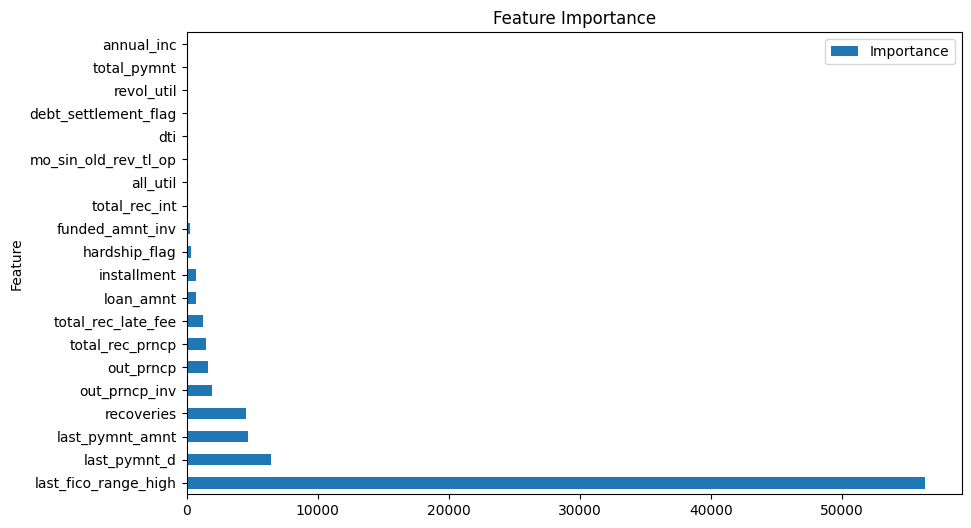

In [38]:
feature_importance = model.varimp(use_pandas=True)  # Get feature importance using varimp and convert to pandas DataFrame


importance_df = feature_importance[['variable', 'relative_importance']].rename(columns={'variable': 'Feature', 'relative_importance': 'Importance'})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

importance_df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

### **PDP**

In [39]:
column = 'loan_amnt'

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


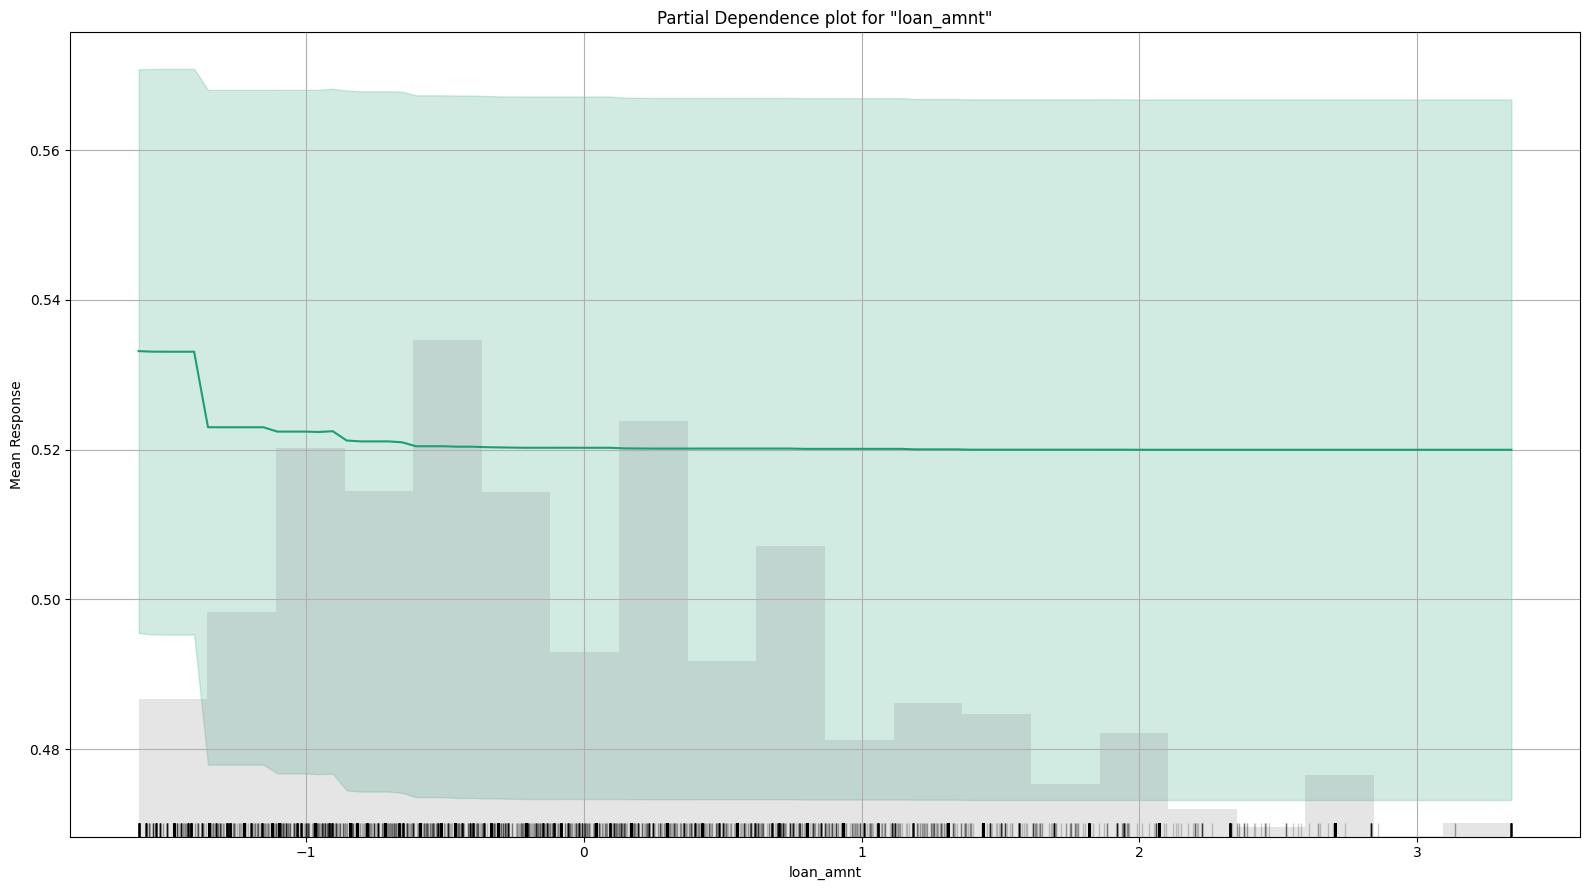

In [40]:
model.pd_plot(h2o.H2OFrame(X_test), column)

### **SHAP summary plot**

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/explanation/_explain.py:611: RuntimeWarning: invalid value encountered in divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


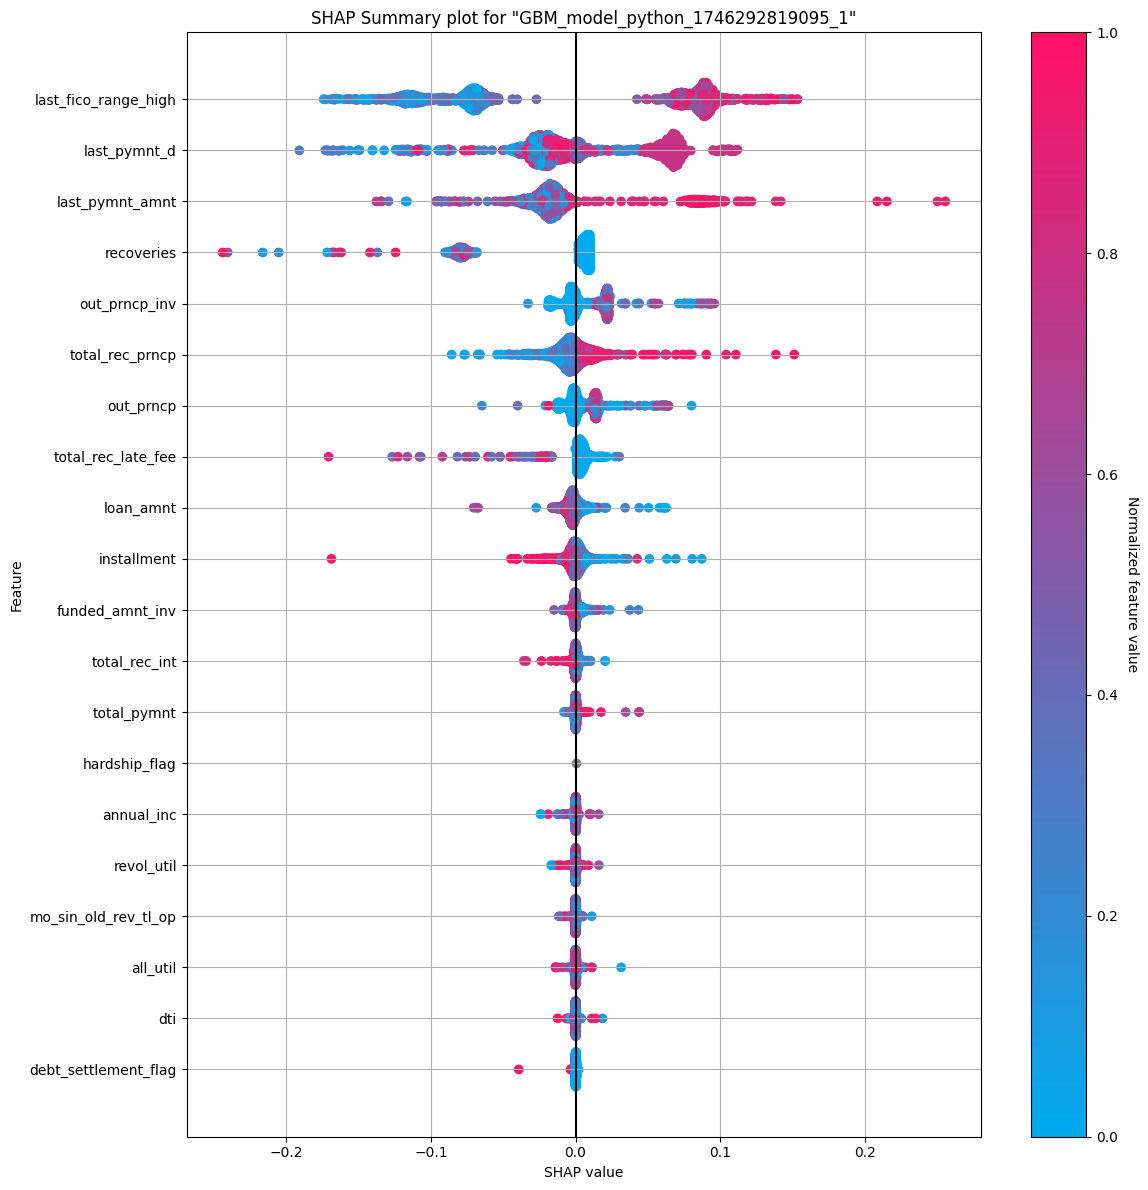

In [41]:
model.shap_summary_plot(h2o.H2OFrame(X_test)) # Convert X_test to H2OFrame before passing it to the function

- **last_fico_range** and **last_pymnt_d** have a higher total impact on predicting whether a person will default on the loan than other features.

### **LIME**

In [43]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['loan_status'],
    mode='classification',
    discretize_continuous=False
)

def predict_fn(data):
    h2o_frame = h2o.H2OFrame(pd.DataFrame(data, columns=X_train.columns))
    predictions = model.predict(h2o_frame).as_data_frame(use_multi_thread=True)['predict']
    # Convert to probabilities
    probs = [1 - predictions.iloc[i] for i in range(len(predictions))]
    probs = np.array(probs).reshape(-1, 1)
    probs = np.hstack([probs, 1 - probs])
    return probs

instance = X_test.iloc[0].values

explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_fn,
    num_features=5
)

explanation.show_in_notebook(show_table=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


**last_fico_range_high** was the most influential feature supporting the prediction (class 1), while **recoveries** and others pushed against it.